# ConSBind Tutorial - Programmatic Usage
***

## Overview

ConSBind (Consensus Structural Binding site predictor) identifies potential binding sites 
in protein structures using a consensus of geometric and energy-based approaches. 
This tutorial demonstrates how to use the ConSBind package programmatically 
for predicting protein binding sites.

Let's get started!

## Setup

First, let's import the necessary modules and set up logging.

In [1]:
import os
import sys
import logging
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image, display, HTML
from Bio.PDB import PDBParser, Selection
import Bio.PDB.PDBList

# Import ConSBind modules
from ConSBind.input.file_handler import convert_ent_to_pdb, find_pdb_files
from ConSBind.core.structure import ProteinStructure
from ConSBind.core.finder import ConsensusPocketFinder
from ConSBind.core.scoring import final_scoring
from ConSBind.output.output import save_predictions, save_pymol, save_chimera

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger('ConSBind-Tutorial')

## Example 1: Analysis of HIV-1 protease

### Download and Prepare Protein Structure

First, we'll download the HIV-1 protease with indinavir (PDB ID: `1HSG`) using BioPython's PDBList module.

In [2]:
pdblist = Bio.PDB.PDBList()
pdb_id = "1hsg" 
os.makedirs("data/tutorial", exist_ok=True)

print(f"Downloading PDB ID: {pdb_id} in PDB format...")
pdblist.retrieve_pdb_file(pdb_id, file_format="pdb", pdir="data/tutorial")
    
# PDBList downloads files with .ent extension
ent_file = Path(f"data/tutorial/pdb{pdb_id}.ent")
    
print(f"Downloaded PDB file to {ent_file}")

# Convert .ent to .pdb using ConSBind's file handler
pdb_file = str(convert_ent_to_pdb(ent_file))
print(f"Converted to PDB format: {pdb_file}")

2025-03-28 16:15:29,410 - ConSBind - INFO - Converting .ent file to .pdb format: pdb1hsg.ent
2025-03-28 16:15:29,413 - ConSBind - INFO - Converted to: pdb1hsg.pdb


Structure exists: 'data/tutorial/pdb1hsg.ent' 
Downloaded PDB file to data/tutorial/pdb1hsg.ent
Converted to PDB format: /var/folders/jh/bm1wh6mn3ms2596tlzslwrdw0000gn/T/consbind_temp/pdb1hsg.pdb


### Load Protein Structure

Now that we have a PDB file, we can load it using ConSBind's ProteinStructure class.
This class handles parsing the PDB file and preparing it for binding site prediction.

In [3]:
try:
    print(f"Loading protein structure from {pdb_file}...")
    protein = ProteinStructure(pdb_file)
    print("Protein structure loaded successfully!")
    
except Exception as e:
    print(f"Error loading protein structure: {str(e)}")
    sys.exit(1)

Loading protein structure from /var/folders/jh/bm1wh6mn3ms2596tlzslwrdw0000gn/T/consbind_temp/pdb1hsg.pdb...
Protein structure loaded successfully!


### Analyze Protein Structure

Let's examine the protein structure to understand its properties.

In [4]:
# Basic protein information
print(f"Protein ID: {protein.pdb_id}")
print(f"Number of chains: {len(protein.model.child_list)}")

# Count residues and atoms
residues = Selection.unfold_entities(protein.structure, 'R')
atoms = Selection.unfold_entities(protein.structure, 'A')
print(f"Number of residues: {len(residues)}")
print(f"Number of atoms: {len(atoms)}")

Protein ID: pdb1hsg
Number of chains: 2
Number of residues: 326
Number of atoms: 1686


### Visualize Protein Structure

Let's create a 3D visualization of the protein structure to better understand its shape.

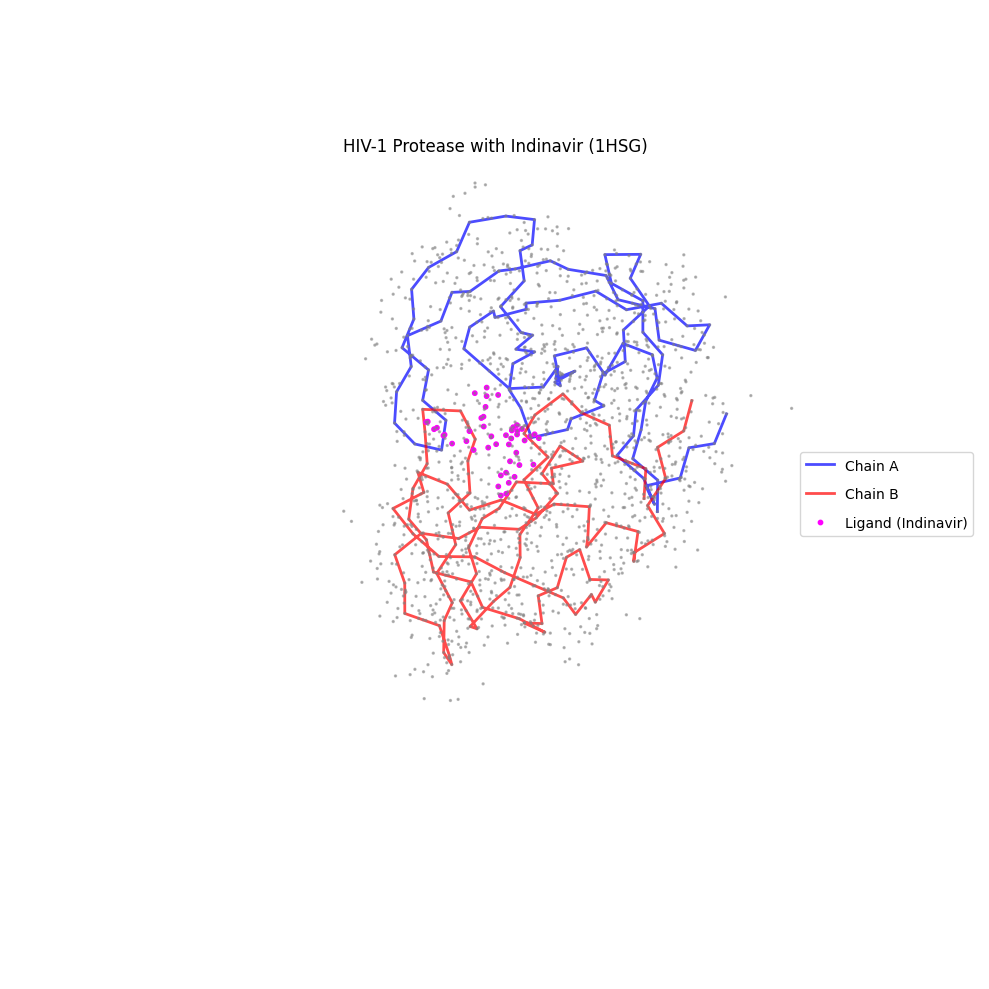

In [5]:
def plot_protein_structure(protein, title="Protein Structure"):
    """Plot protein structure in 3D"""
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_axis_off()
    
    # Get coordinates of all atoms
    atoms = Selection.unfold_entities(protein.structure, 'A')
    coords = np.array([atom.get_coord() for atom in atoms])
    
    # Plot atoms as points
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], s=2, alpha=0.5, c='gray')
    
    # Plot chains with different colors
    chain_colors = ['blue', 'red', 'green', 'purple', 'orange', 'cyan']
    
    for i, chain in enumerate(protein.structure.get_chains()):  # FIX: iterate correctly
        chain_atoms = Selection.unfold_entities(chain, 'A')
        chain_coords = np.array([atom.get_coord() for atom in chain_atoms])
        
        # Use modulo to handle more chains than colors
        color = chain_colors[i % len(chain_colors)]
        
        # Plot chain backbone
        ca_atoms = [atom for atom in chain_atoms if atom.get_name() == 'CA']
        if ca_atoms:
            ca_coords = np.array([atom.get_coord() for atom in ca_atoms])
            ax.plot(ca_coords[:, 0], ca_coords[:, 1], ca_coords[:, 2], 
                    color=color, linewidth=2, alpha=0.7, label=f'Chain {chain.get_id()}')

    # Find ligand (MK1 atoms only)
    lig = [atom for atom in atoms if atom.get_parent().get_resname() == 'MK1']
    
    if lig:
        lig_coords = np.array([atom.get_coord() for atom in lig])
        ax.scatter(lig_coords[:, 0], lig_coords[:, 1], lig_coords[:, 2], 
                   s=10, c='magenta', alpha=1.0, label='Ligand (Indinavir)')

    # Set labels and title
    ax.set_xlabel('X (Å)')
    ax.set_ylabel('Y (Å)')
    ax.set_zlabel('Z (Å)')
    ax.set_title(title, y=0.95, pad=-14)
    
    # Add legend
    ax.legend(fontsize=10, handleheight=1.2, labelspacing=1, loc = 'center right')
    
    # Set equal aspect ratio
    max_range = np.array([
        coords[:, 0].max() - coords[:, 0].min(),
        coords[:, 1].max() - coords[:, 1].min(),
        coords[:, 2].max() - coords[:, 2].min()
    ]).max() / 2.0
    
    mid_x = (coords[:, 0].max() + coords[:, 0].min()) * 0.5
    mid_y = (coords[:, 1].max() + coords[:, 1].min()) * 0.5
    mid_z = (coords[:, 2].max() + coords[:, 2].min()) * 0.5
    
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    plt.tight_layout()
    return fig

# Plot the protein structure
fig = plot_protein_structure(protein, title="HIV-1 Protease with Indinavir (1HSG)")
plt.show()

### Predict Binding Sites

Now let's use ConSBind to predict binding sites in the protein structure.
We'll use both geometric and energy-based approaches and then combine them.

In [6]:
# Create consensus pocket finder
pocket_finder = ConsensusPocketFinder()

# 1. Find pockets using geometric approach
print("Finding geometric pockets...")
geometric_pockets = pocket_finder.find_pockets_geometric(
    protein, 
    probe_radius=1.4,
    min_size=5
)
print(f"Found {len(geometric_pockets)} geometric pockets")

# 2. Find pockets using energy-based approach
print("Finding energy-based pockets...")
energy_pockets = pocket_finder.find_pockets_energy(
    protein,
    grid_spacing=1.0
)
print(f"Found {len(energy_pockets)} energy-based pockets")

# 3. Combine results for consensus
print("Combining results...")
consensus_pockets = pocket_finder.combine_pockets(protein, geometric_pockets, energy_pockets)
print(f"Found {len(consensus_pockets)} consensus pockets")

# 4. Score pockets
print("Scoring pockets...")
protein_type = "enzyme"  # HIV-1 protease is an enzyme
scored_pockets = final_scoring(consensus_pockets, protein_type)
print(f"Final selection: {len(scored_pockets)} significant pockets")

2025-03-28 16:15:30,970 - ConSBind - INFO - Created grid with dimensions: 58x81x75


Finding geometric pockets...


2025-03-28 16:15:31,741 - ConSBind - INFO - Found 503 potential cavity points
2025-03-28 16:15:31,745 - ConSBind - INFO - Found 20 cavities after clustering
2025-03-28 16:15:31,746 - ConSBind - INFO - Identified 806 surface atoms
2025-03-28 16:15:31,746 - ConSBind - INFO - Calculating energy scores for grid points...


Found 20 geometric pockets
Finding energy-based pockets...


2025-03-28 16:15:41,020 - ConSBind - INFO - Found 91 high-energy points
2025-03-28 16:15:41,023 - ConSBind - INFO - Found 7 energy-based pockets after clustering
2025-03-28 16:15:41,084 - ConSBind - INFO - Combined into 26 consensus pockets
2025-03-28 16:15:41,085 - ConSBind - INFO - Automatic filtering identified 1 significant pockets out of 26 total
2025-03-28 16:15:41,085 - ConSBind - INFO - Only one pocket found, keeping it without statistical filtering
2025-03-28 16:15:41,085 - ConSBind - INFO - Final selection: 1 pockets with scores ranging from 16.55 to 16.55


Found 7 energy-based pockets
Combining results...
Found 26 consensus pockets
Scoring pockets...
Final selection: 1 significant pockets


## Analyze Binding Site Predictions

Let's analyze the predicted binding sites in more detail.

In [7]:
# Create a DataFrame for easier analysis
pocket_data = []
for i, pocket in enumerate(scored_pockets, 1):
    pocket_dict = {
        'Pocket': i,
        'Consensus Score': pocket['consensus_score'],
        'Final Score': pocket['final_score'],
        'Size': pocket['size'],
        'X': pocket['center'][0],
        'Y': pocket['center'][1],
        'Z': pocket['center'][2]
    }
    
    # Add other scores if available
    if 'druggability' in pocket:
        pocket_dict['Druggability'] = pocket['druggability']
    if 'knowledge_score' in pocket:
        pocket_dict['Knowledge Score'] = pocket['knowledge_score']
    if 'hydrophobicity' in pocket:
        pocket_dict['Hydrophobicity'] = pocket['hydrophobicity']
    if 'electrostatics' in pocket:
        pocket_dict['Electrostatics'] = pocket['electrostatics']
        
    pocket_data.append(pocket_dict)

pockets_df = pd.DataFrame(pocket_data)
display(pockets_df)

Pocket  Consensus Score  Final Score  Size          X          Y         Z  \
0       1              3.9       16.545    28  17.151428  15.577429 -7.765288   

   Druggability  Knowledge Score  
0          0.49              3.0

### Visualize Binding Sites

Let's visualize the predicted binding sites in the protein structure.

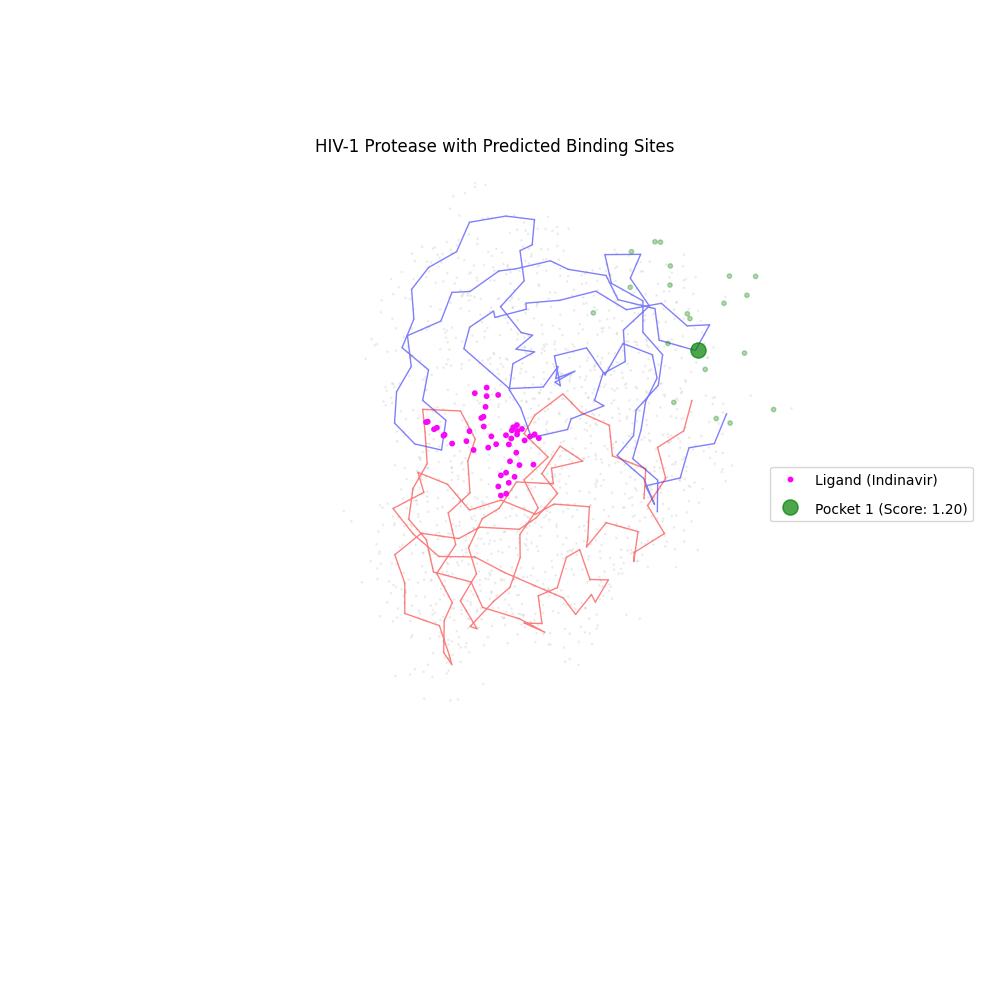

In [33]:
# Plot the protein with predicted binding sites
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_axis_off()
    
# Get coordinates of all atoms
atoms = Selection.unfold_entities(protein.structure, 'A')
coords = np.array([atom.get_coord() for atom in atoms])
    
# Plot atoms as points with low alpha for transparency
ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], s=1, alpha=0.1, c='gray')
    
# Plot chains with different colors
chain_colors = ['blue', 'red']
    
for i, chain in enumerate(protein.model):
    chain_atoms = Selection.unfold_entities(chain, 'A')
        
    # Plot chain backbone
    ca_atoms = [atom for atom in chain_atoms if atom.get_name() == 'CA']
    if ca_atoms:
        ca_coords = np.array([atom.get_coord() for atom in ca_atoms])
        ax.plot(ca_coords[:, 0], ca_coords[:, 1], ca_coords[:, 2], 
                color=chain_colors[i % len(chain_colors)], linewidth=1, alpha=0.5)
    
# Find ligand (MK1 atoms only)
lig = [atom for atom in atoms if atom.get_parent().get_resname() == 'MK1']
    
if lig:
    lig_coords = np.array([atom.get_coord() for atom in lig])
    ax.scatter(lig_coords[:, 0], lig_coords[:, 1], lig_coords[:, 2], 
                s=10, c='magenta', alpha=1.0, label='Ligand (Indinavir)')    
# Plot binding sites
pocket_colors = ['green','limegreen', 'yellow', 'orange', 'red']
for i, pockets in enumerate(scored_pockets):
    center = pocket['center']
    score = pocket['consensus_score']
        
    # Scale size by score
    size = 100 * score
        
    # Use modulo to handle more pockets than colors
    color = pocket_colors[i % len(pocket_colors)]
        
    ax.scatter(center[0], center[1], center[2], s=size, c=color, alpha=0.7, 
                label=f'Pocket {i+1} (Score: {score:.2f})')
        
    # Plot pocket points if available
    if 'points' in pocket and len(pocket['points']) > 0:
        points = pocket['points']
        if isinstance(points, np.ndarray) and len(points) > 0:
            # Limit number of points to avoid cluttering
            if len(points) > 20:
                indices = np.random.choice(len(points), 20, replace=False)
                points = points[indices]
                
            ax.scatter(points[:, 0], points[:, 1], points[:, 2], 
                       s=10, c=color, alpha=0.3)
    
# Set labels and title
ax.set_xlabel('X (Å)')
ax.set_ylabel('Y (Å)')
ax.set_zlabel('Z (Å)')
ax.set_title("HIV-1 Protease with Predicted Binding Sites", y=0.95, pad=-14)
    
# Add legend
ax.legend(fontsize=10, handleheight=1.2, labelspacing=1, loc = 'center right')

    
# Set equal aspect ratio
max_range = np.array([
    coords[:, 0].max() - coords[:, 0].min(),
    coords[:, 1].max() - coords[:, 1].min(),
    coords[:, 2].max() - coords[:, 2].min()
]).max() / 2.0
    
mid_x = (coords[:, 0].max() + coords[:, 0].min()) * 0.5
mid_y = (coords[:, 1].max() + coords[:, 1].min()) * 0.5
mid_z = (coords[:, 2].max() + coords[:, 2].min()) * 0.5
    
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
plt.tight_layout()
plt.show()

### Compare Predicted Sites with Known Binding Site

The HIV-1 protease (1HSG) has a known binding site where the inhibitor indinavir binds.
Let's compare our predictions with this known binding site.

In [9]:
def find_ligand_binding_site(protein,ligname):
    """Find the binding site of a ligand in the protein structure
    """
    # Get all atoms
    atoms = Selection.unfold_entities(protein.structure, 'A')

    
    # Calculate ligand center
    lig = [atom for atom in atoms if atom.get_parent().get_resname() == ligname]
    ligand_coords = np.array([atom.get_coord() for atom in lig])
    ligand_center = np.mean(ligand_coords, axis=0)
    
    # Define standard amino acid names
    standard_aa_names = set([
        'ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS',
        'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP',
        'TYR', 'VAL'
    ])
    
    # Find protein residues near the ligand (binding site)
    binding_site_residues = []
    for residue in Selection.unfold_entities(protein.structure, 'R'):
        # Skip non-amino acid residues
        if residue.get_resname() not in standard_aa_names:
            continue
        
        # Check if any atom in the residue is close to the ligand
        for atom in residue:
            min_dist = min([np.linalg.norm(atom.get_coord() - ligand_atom.get_coord()) 
                            for ligand_atom in lig])
            if min_dist < 4.0:  # 4Å cutoff for binding site
                binding_site_residues.append(residue)
                break
    
    # Create binding site dictionary
    binding_site = {
        'center': ligand_center,
        'size': len(binding_site_residues),
        'residues': [(res.get_parent().id, res.get_id()[1], res.get_resname()) 
                     for res in binding_site_residues]
    }
    
    return binding_site

# Find the actual binding site
actual_binding_site = find_ligand_binding_site(protein, 'MK1')

if actual_binding_site:
    print(f"Actual binding site:")
    print(f"Center: {actual_binding_site['center']}")
    print(f"Size: {actual_binding_site['size']} residues")
    print("\nBinding site residues:")
    for chain, resid, resname in actual_binding_site['residues']:
        print(f"  {chain}:{resname}{resid}")

Actual binding site:
Center: [13.072668 22.467356  5.55749 ]
Size: 26 residues

Binding site residues:
  A:ARG8
  A:LEU23
  A:ASP25
  A:GLY27
  A:ALA28
  A:VAL32
  A:ILE47
  A:GLY48
  A:GLY49
  A:PRO81
  A:VAL82
  A:ILE84
  B:ARG8
  B:ASP25
  B:GLY27
  B:ALA28
  B:ASP29
  B:ASP30
  B:VAL32
  B:ILE47
  B:GLY48
  B:GLY49
  B:ILE50
  B:PRO81
  B:VAL82
  B:ILE84


### Compare Predictions with Actual Binding Site

Pocket  Distance to Actual Site (Å)  Consensus Score  Final Score
0       1                    15.543609              3.9       16.545

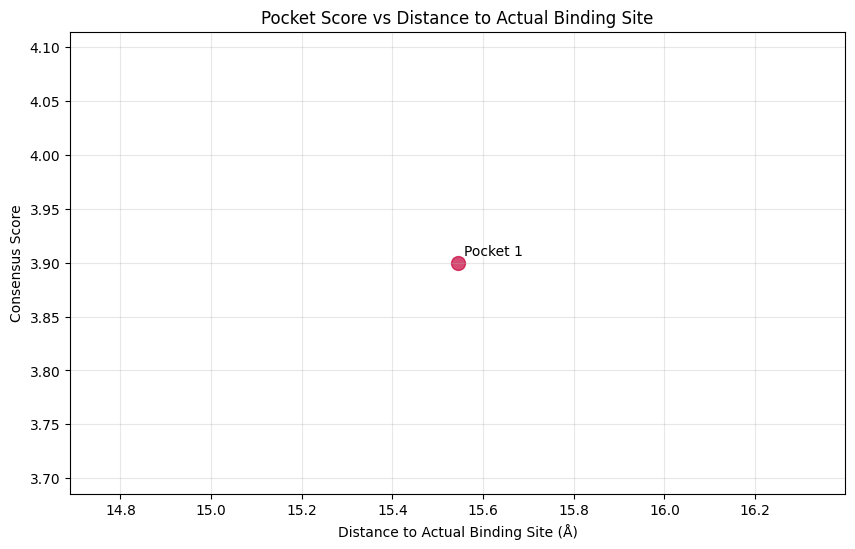

In [10]:
def calculate_distance(point1, point2):
    """Calculate Euclidean distance between two points"""
    return np.linalg.norm(np.array(point1) - np.array(point2))

# Calculate distances between predicted pockets and actual binding site
if actual_binding_site:
    actual_center = actual_binding_site['center']
    
    distances = []
    for i, pocket in enumerate(scored_pockets, 1):
        dist = calculate_distance(pocket['center'], actual_center)
        distances.append({
            'Pocket': i,
            'Distance to Actual Site (Å)': dist,
            'Consensus Score': pocket['consensus_score'],
            'Final Score': pocket['final_score']
        })
    
    # Create DataFrame and sort by distance
    distances_df = pd.DataFrame(distances)
    distances_df = distances_df.sort_values('Distance to Actual Site (Å)')
    display(distances_df)
    
    # Plot distance vs score
    plt.figure(figsize=(10, 6))
    plt.scatter(distances_df['Distance to Actual Site (Å)'], 
                distances_df['Consensus Score'], 
                s=100, alpha=0.7, color='#C70039')
    
    # Add labels to points
    for i, row in distances_df.iterrows():
        plt.annotate(f"Pocket {int(row['Pocket'])}", 
                     (row['Distance to Actual Site (Å)'], row['Consensus Score']),
                     xytext=(5, 5), textcoords='offset points')
    
    plt.xlabel('Distance to Actual Binding Site (Å)')
    plt.ylabel('Consensus Score')
    plt.title('Pocket Score vs Distance to Actual Binding Site')
    plt.grid(True, alpha=0.3)
    plt.show()

### Visualize Binding Site Properties

Let's analyze the properties of the predicted binding sites in more detail.

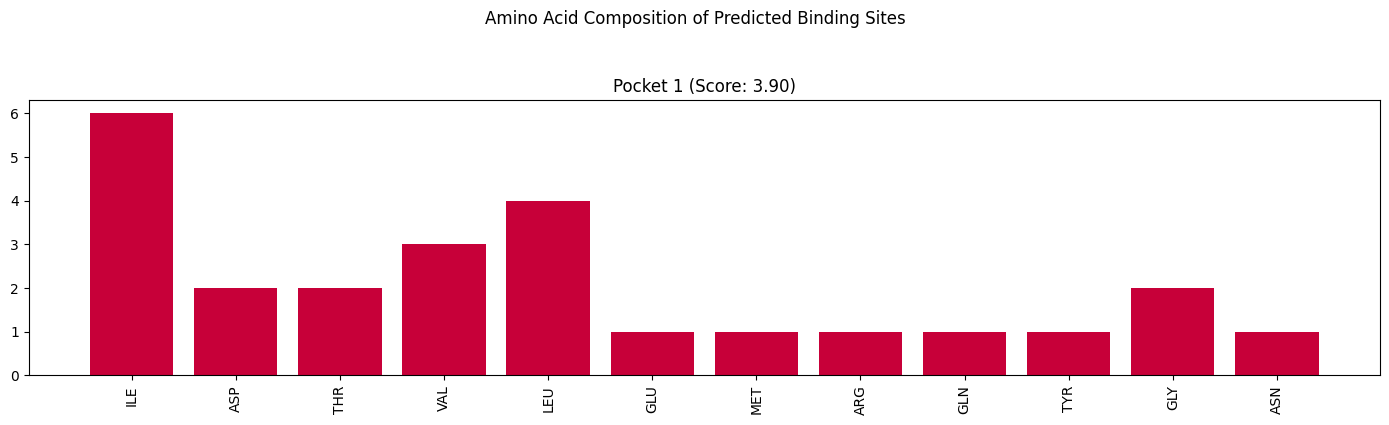

In [12]:
# Extract residues for each pocket
pocket_residues = []
for i, pocket in enumerate(scored_pockets, 1):
    residues = protein.get_pocket_residues(pocket)
    pocket_residues.append({
        'Pocket': i,
        'Residues': residues,
        'Score': pocket['consensus_score']
    })

# Calculate amino acid composition for each pocket
aa_counts = []
for pocket in pocket_residues:
    # Count amino acids by type
    aa_count = {}
    for _, _, resname in pocket['Residues']:
        if resname in aa_count:
            aa_count[resname] += 1
        else:
            aa_count[resname] = 1
    
    # Add pocket info
    aa_count['Pocket'] = pocket['Pocket']
    aa_count['Score'] = pocket['Score']
    aa_counts.append(aa_count)

aa_df = pd.DataFrame(aa_counts)
aa_df = aa_df.fillna(0) 

# Plot amino acid composition
plt.figure(figsize=(14, 4))
for i, pocket in enumerate(aa_counts):
    pocket_id = pocket['Pocket']
    
    # Extract amino acid counts
    aa_names = [col for col in aa_df.columns if col not in ['Pocket', 'Score']]
    aa_values = [pocket.get(aa, 0) for aa in aa_names]

    # Plot
    plt.subplot(1, len(aa_counts), i+1)
    plt.bar(aa_names, aa_values, color= '#C70039')
    plt.title(f'Pocket {pocket_id} (Score: {pocket["Score"]:.2f})')
    plt.xticks(rotation=90)
    plt.tight_layout()

plt.suptitle('Amino Acid Composition of Predicted Binding Sites', y=1.05)
plt.tight_layout()
plt.show()

### Programmatic Access to Pocket Data

Let's demonstrate how to access and work with the pocket data programmatically.

In [13]:
# Example: Find the highest scoring pocket
highest_scoring = max(scored_pockets, key=lambda x: x['consensus_score'])
print(f"Highest scoring pocket:")
print(f"Consensus Score: {highest_scoring['consensus_score']:.2f}")
print(f"Final Score: {highest_scoring['final_score']:.2f}")
print(f"Size: {highest_scoring['size']}")
print(f"Center: {highest_scoring['center']}")

# Example: Calculate average properties of all pockets
avg_consensus = np.mean([p['consensus_score'] for p in scored_pockets])
avg_size = np.mean([p['size'] for p in scored_pockets])
print(f"\nAverage properties:")
print(f"Average Consensus Score: {avg_consensus:.2f}")
print(f"Average Size: {avg_size:.2f}")

# Example: Find pockets with specific properties
large_pockets = [p for p in scored_pockets if p['size'] > 100]
print(f"\nNumber of large pockets (size > 100): {len(large_pockets)}")

high_scoring = [p for p in scored_pockets if p['consensus_score'] > 0.7]
print(f"Number of high-scoring pockets (score > 0.7): {len(high_scoring)}")

Highest scoring pocket:
Consensus Score: 3.90
Final Score: 16.55
Size: 28
Center: [17.1514285  15.57742909 -7.76528822]

Average properties:
Average Consensus Score: 3.90
Average Size: 28.00

Number of large pockets (size > 100): 0
Number of high-scoring pockets (score > 0.7): 1


### Save visualizations scripts

In [22]:
# Create output directory
output_dir = "results/tutorial"
os.makedirs(output_dir, exist_ok=True)
output_prefix = os.path.join(output_dir, protein.pdb_id)

# 1. Save predictions to text and PDB files
output_file, output_pdb = save_predictions(scored_pockets, protein, output_prefix)
print(f"Predictions saved to {output_file}")
print(f"Modified PDB saved to {output_pdb}")

# 2. Generate PyMOL visualization script
pymol_script = save_pymol(scored_pockets, protein, output_prefix, output_pdb)
print(f"PyMOL script saved to {pymol_script}")

# 3. Generate Chimera visualization script
chimera_script = save_chimera(scored_pockets, protein, output_prefix, output_pdb)
print(f"Chimera script saved to {chimera_script}")

FileNotFoundError: [Errno 2] No such file or directory: '/var/folders/jh/bm1wh6mn3ms2596tlzslwrdw0000gn/T/consbind_temp/pdb1hsg.pdb'

## Example 2: Comparing Apo and Holo Forms of a Protein

A common analysis in structural biology is comparing the binding sites of a protein in its apo (unbound) and holo (ligand-bound) forms. This comparison can reveal conformational changes that occur upon ligand binding.

For this example, we'll use Retinol Binding Protein II (CRBP-II) from human, compared to CRBP from zebrafish bound to retinol:
- Apo form: 2RCQ (open conformation)
- Holo form: 1KQW (closed conformation with glycine betaine)

In [15]:
# Download and prepare both structures
print("Downloading and preparing apo and holo structures...")

# Download apo structure
apo_pdb_id = "2RCQ"
pdblist.retrieve_pdb_file(apo_pdb_id, file_format="pdb", pdir="data/tutorial")
apo_ent_file = Path(f"data/tutorial/pdb{apo_pdb_id}.ent")
apo_pdb_file = str(convert_ent_to_pdb(apo_ent_file))
print(f"Apo structure prepared: {apo_pdb_file}")

# Download holo-structure
holo_pdb_id = "1KQW"
pdblist.retrieve_pdb_file(holo_pdb_id, file_format="pdb", pdir="data/tutorial")
holo_ent_file = Path(f"data/tutorial/pdb{holo_pdb_id}.ent")
holo_pdb_file = str(convert_ent_to_pdb(holo_ent_file))
print(f"Holo structure prepared: {holo_pdb_file}")

2025-03-28 16:15:41,429 - ConSBind - INFO - Converting .ent file to .pdb format: pdb2RCQ.ent
2025-03-28 16:15:41,431 - ConSBind - INFO - Converted to: pdb2RCQ.pdb
2025-03-28 16:15:41,431 - ConSBind - INFO - Converting .ent file to .pdb format: pdb1KQW.ent
2025-03-28 16:15:41,432 - ConSBind - INFO - Converted to: pdb1KQW.pdb


Structure exists: 'data/tutorial/pdb2rcq.ent' 
Apo structure prepared: /var/folders/jh/bm1wh6mn3ms2596tlzslwrdw0000gn/T/consbind_temp/pdb2RCQ.pdb
Structure exists: 'data/tutorial/pdb1kqw.ent' 
Holo structure prepared: /var/folders/jh/bm1wh6mn3ms2596tlzslwrdw0000gn/T/consbind_temp/pdb1KQW.pdb


In [16]:
import warnings

# Suppress the specific warning about pdbx_label_seq_id
warnings.filterwarnings("ignore", message="Requested item not allowed in category according to dictionary; category: atom_site; item: pdbx_label_seq_id")

# Load both structures
apo_protein = ProteinStructure(apo_pdb_file)
holo_protein = ProteinStructure(holo_pdb_file)

print("Structures loaded successfully!")
print(f"Apo structure: {len(Selection.unfold_entities(apo_protein.structure, 'R'))} residues")
print(f"Holo structure: {len(Selection.unfold_entities(holo_protein.structure, 'R'))} residues")

Structures loaded successfully!
Apo structure: 300 residues
Holo structure: 329 residues


In [17]:
# Predict binding sites for both structures
pocket_finder = ConsensusPocketFinder()

# Process apo structure
apo_geometric = pocket_finder.find_pockets_geometric(apo_protein)
apo_energy = pocket_finder.find_pockets_energy(apo_protein)
apo_consensus = pocket_finder.combine_pockets(apo_protein, apo_geometric, apo_energy)
apo_pockets = final_scoring(apo_consensus, "transporter")  # CRBP is an enzyme

# Process holo structure
holo_geometric = pocket_finder.find_pockets_geometric(holo_protein)
holo_energy = pocket_finder.find_pockets_energy(holo_protein)
holo_consensus = pocket_finder.combine_pockets(holo_protein, holo_geometric, holo_energy)
holo_pockets = final_scoring(holo_consensus, "transporter")

2025-03-28 16:15:44,556 - ConSBind - INFO - Created grid with dimensions: 59x56x62
2025-03-28 16:15:45,394 - ConSBind - INFO - Found 645 potential cavity points
2025-03-28 16:15:45,400 - ConSBind - INFO - Found 13 cavities after clustering
2025-03-28 16:15:45,400 - ConSBind - INFO - Identified 673 surface atoms
2025-03-28 16:15:45,400 - ConSBind - INFO - Calculating energy scores for grid points...
2025-03-28 16:15:53,275 - ConSBind - INFO - Found 19 high-energy points
2025-03-28 16:15:53,275 - ConSBind - INFO - Found 1 energy-based pockets after clustering
2025-03-28 16:15:53,303 - ConSBind - INFO - Combined into 14 consensus pockets
2025-03-28 16:15:53,304 - ConSBind - INFO - Automatic filtering identified 1 significant pockets out of 14 total
2025-03-28 16:15:53,304 - ConSBind - INFO - Only one pocket found, keeping it without statistical filtering
2025-03-28 16:15:53,304 - ConSBind - INFO - Final selection: 1 pockets with scores ranging from 49.67 to 49.67
2025-03-28 16:15:53,305 -

In [18]:
# Find the actual binding site in the holo structure
holo_binding_site = find_ligand_binding_site(holo_protein, 'RTL')

if holo_binding_site:
    print("\nActual binding site in holo structure:")
    print(f"Center: {holo_binding_site['center']}")
    print(f"Size: {holo_binding_site['size']} residues")


Actual binding site in holo structure:
Center: [14.192191  55.58681    3.0083811]
Size: 15 residues


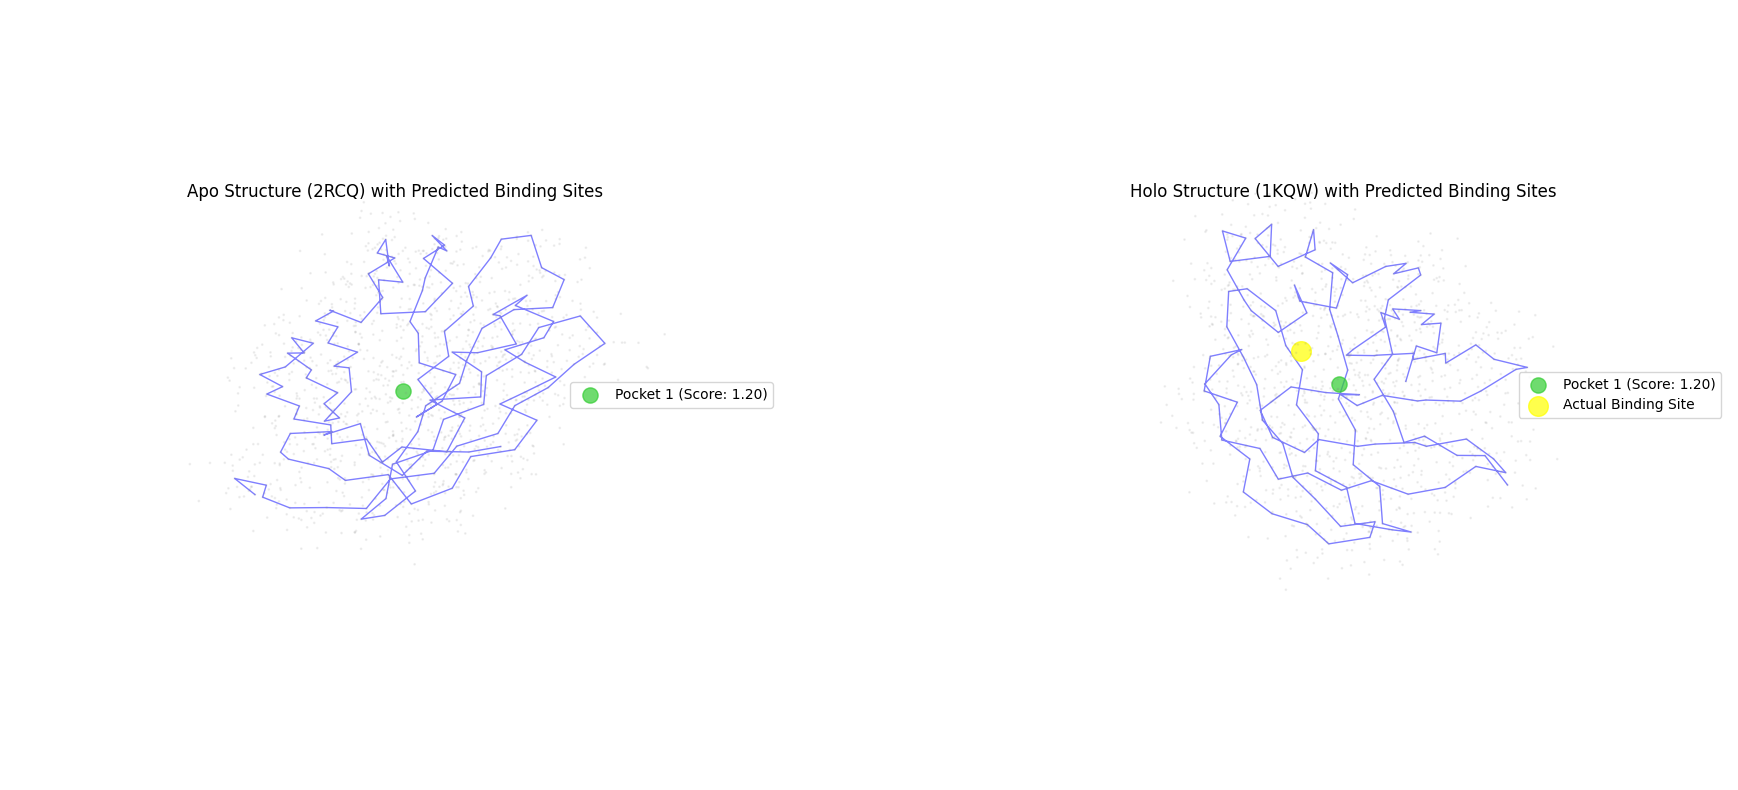

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8), subplot_kw={'projection': '3d'})

# Plot apo structure
ax = axes[0]
ax.set_axis_off()
atoms = Selection.unfold_entities(apo_protein.structure, 'A')
coords = np.array([atom.get_coord() for atom in atoms])
ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], s=1, alpha=0.1, c='gray')

chain_colors = ['blue']
    
for i, chain in enumerate(apo_protein.model):
    chain_atoms = Selection.unfold_entities(chain, 'A')
        
    # Plot chain backbone
    ca_atoms = [atom for atom in chain_atoms if atom.get_name() == 'CA']
    if ca_atoms:
        ca_coords = np.array([atom.get_coord() for atom in ca_atoms])
        ax.plot(ca_coords[:, 0], ca_coords[:, 1], ca_coords[:, 2], 
                color=chain_colors[i % len(chain_colors)], linewidth=1, alpha=0.5)
        
# Plot apo binding sites
for i, pocket in enumerate(apo_pockets):
    center = pocket['center']
    score = pocket['consensus_score']
    size = 100 * score
    color = ['limegreen', 'orange', 'magenta', 'cyan', 'red'][i % 5]
    ax.scatter(center[0], center[1], center[2], s=size, c=color, alpha=0.7, 
               label=f'Pocket {i+1} (Score: {score:.2f})')

ax.set_title('Apo Structure (2RCQ) with Predicted Binding Sites',  y=0.85, pad=-14)
ax.legend(loc = 'center right')

# Plot holo structure
ax = axes[1]
ax.set_axis_off()
atoms = Selection.unfold_entities(holo_protein.structure, 'A')
coords = np.array([atom.get_coord() for atom in atoms])
ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], s=1, alpha=0.1, c='gray')
    
for i, chain in enumerate(holo_protein.model):
    chain_atoms = Selection.unfold_entities(chain, 'A')
        
    # Plot chain backbone
    ca_atoms = [atom for atom in chain_atoms if atom.get_name() == 'CA']
    if ca_atoms:
        ca_coords = np.array([atom.get_coord() for atom in ca_atoms])
        ax.plot(ca_coords[:, 0], ca_coords[:, 1], ca_coords[:, 2], 
                color=chain_colors[i % len(chain_colors)], linewidth=1, alpha=0.5)

# Plot holo binding sites
for i, pocket in enumerate(holo_pockets):
    center = pocket['center']
    score = pocket['consensus_score']
    size = 100 * score
    color = ['limegreen', 'orange', 'magenta', 'cyan', 'red'][i % 5]
    ax.scatter(center[0], center[1], center[2], s=size, c=color, alpha=0.7, 
               label=f'Pocket {i+1} (Score: {score:.2f})')

# Plot actual binding site
if holo_binding_site:
    center = holo_binding_site['center']
    ax.scatter(center[0], center[1], center[2], s=200, c='yellow', alpha=0.7, 
               label='Actual Binding Site')

ax.set_title('Holo Structure (1KQW) with Predicted Binding Sites',  y=0.85, pad=-14)
ax.legend(loc = 'center right')


plt.tight_layout()
plt.show()

In [20]:
# Compare binding site residues between apo and holo forms
def get_residue_ids(protein, pocket):
    """Get standardized residue IDs for comparison"""
    residues = protein.get_pocket_residues(pocket)
    return set([f"{chain}:{resname}{resid}" for chain, resid, resname in residues])

apo_data = []
for i, pocket in enumerate(apo_pockets, 1):
    residue_ids = get_residue_ids(apo_protein, pocket)
    apo_data.append({
        'Pocket': f"Apo-{i}",
        'Score': pocket['consensus_score'],
        'Size': pocket['size'],
        'Residue_IDs': residue_ids
    })

holo_data = []
for i, pocket in enumerate(holo_pockets, 1):
    residue_ids = get_residue_ids(holo_protein, pocket)
    holo_data.append({
        'Pocket': f"Holo-{i}",
        'Score': pocket['consensus_score'],
        'Size': pocket['size'],
        'Residue_IDs': residue_ids
    })

# Calculate overlap between pockets
overlap_data = []
for apo_entry in apo_data:
    for holo_entry in holo_data:
        apo_residues = apo_entry['Residue_IDs']
        holo_residues = holo_entry['Residue_IDs']
        
        # Calculate overlap
        common_residues = apo_residues.intersection(holo_residues)
        overlap_percent = len(common_residues) / len(apo_residues) * 100 if apo_residues else 0
        
        overlap_data.append({
            'Apo_Pocket': apo_entry['Pocket'],
            'Holo_Pocket': holo_entry['Pocket'],
            'Apo_Score': apo_entry['Score'],
            'Holo_Score': holo_entry['Score'],
            'Common_Residues': len(common_residues),
            'Overlap_Percent': overlap_percent
        })

overlap_df = pd.DataFrame(overlap_data)
overlap_df = overlap_df.sort_values('Overlap_Percent', ascending=False)
display(overlap_df.head(10))

Apo_Pocket Holo_Pocket  Apo_Score  Holo_Score  Common_Residues  \
0      Apo-1      Holo-1        1.2         1.2               10   

   Overlap_Percent  
0        47.619048

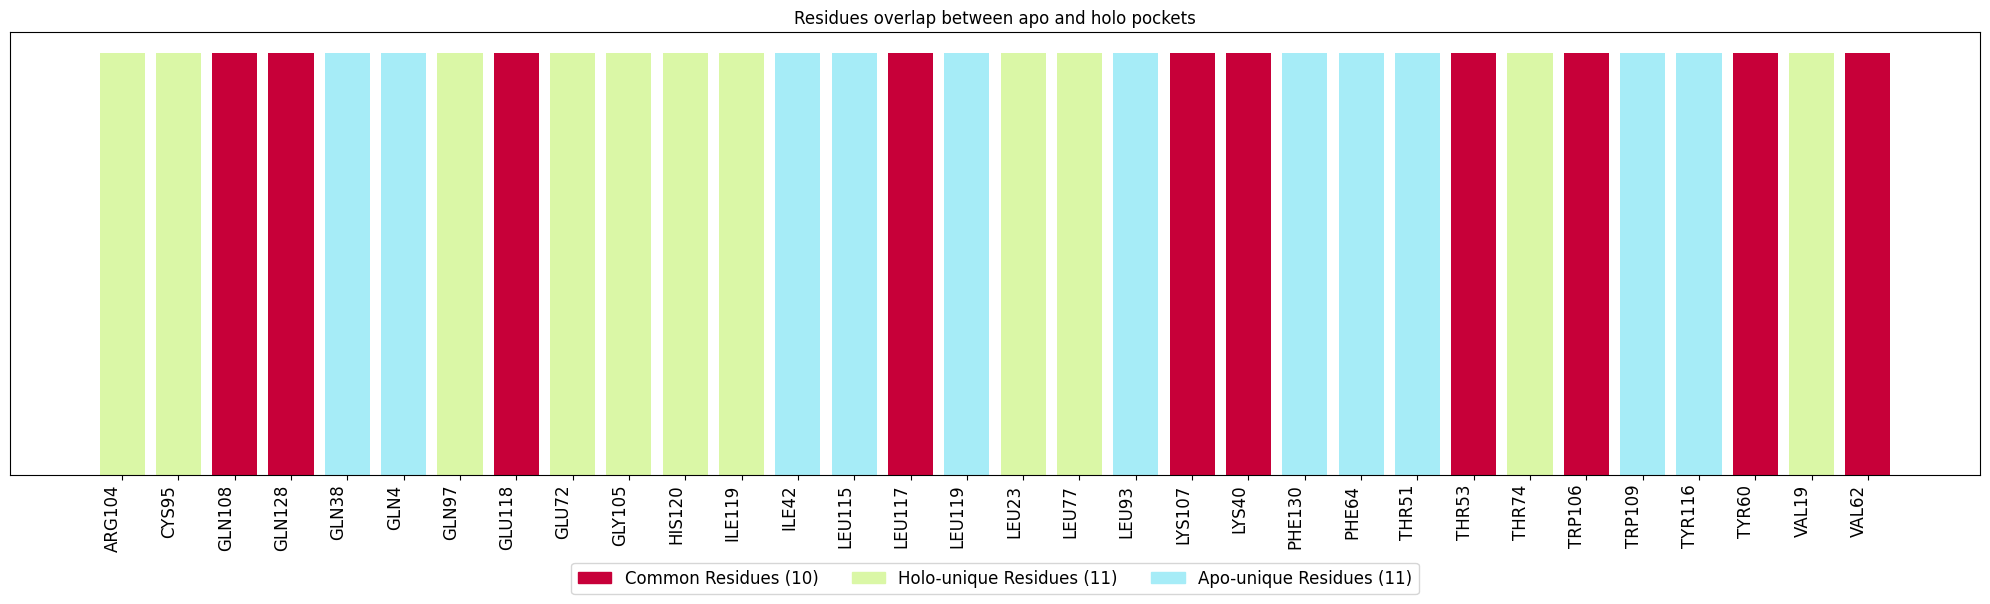

Holo-unique Residue IDs:
['ARG104', 'CYS95', 'GLN97', 'GLU72', 'GLY105', 'HIS120', 'ILE119', 'LEU23', 'LEU77', 'THR74', 'VAL19']

Total Holo-unique residues: 11

Apo-unique Residue IDs:
['GLN38', 'GLN4', 'ILE42', 'LEU115', 'LEU119', 'LEU93', 'PHE130', 'PHE64', 'THR51', 'TRP109', 'TYR116']

Total Apo-unique residues: 11

Common Residue IDs:
['GLN108', 'GLN128', 'GLU118', 'LEU117', 'LYS107', 'LYS40', 'THR53', 'TRP106', 'TYR60', 'VAL62']

Total common residues: 10


In [21]:
# Collect residue IDs
holo_residue_ids = set()
for entry in holo_data:
    holo_residue_ids.update(rid.split(':')[-1] for rid in entry['Residue_IDs'])
apo_residue_ids = set()
for entry in apo_data:
    apo_residue_ids.update(rid.split(':')[-1] for rid in entry['Residue_IDs'])

# Separate sets
common_residues = holo_residue_ids.intersection(apo_residue_ids)
holo_unique_residues = holo_residue_ids - apo_residue_ids
apo_unique_residues = apo_residue_ids - holo_residue_ids

all_residues = sorted(list(holo_residue_ids.union(apo_residue_ids)))
colors = []
for residue in all_residues:
    if residue in common_residues:
        colors.append('#C70039')  
    elif residue in holo_unique_residues:
        colors.append('#DAF7A6')   
    else:
        colors.append('#A6ECF7')    

# Plot
plt.figure(figsize=(20, 6))
bars = plt.bar(range(len(all_residues)), [1]*len(all_residues), color=colors)
plt.yticks([])  
plt.xticks(range(len(all_residues)), all_residues, rotation=90, ha='right', fontsize=12)
plt.title('Residues overlap between apo and holo pockets', fontsize=12)

# Legend
common_patch = mpatches.Patch(color='#C70039', label=f'Common Residues ({len(common_residues)})')
holo_patch = mpatches.Patch(color='#DAF7A6', label=f'Holo-unique Residues ({len(holo_unique_residues)})')
apo_patch = mpatches.Patch(color='#A6ECF7', label=f'Apo-unique Residues ({len(apo_unique_residues)})')

plt.legend(handles=[common_patch, holo_patch, apo_patch], 
           loc='upper center', 
           bbox_to_anchor=(0.5, -0.18),  
           ncol=3,
          fontsize=12)  

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  
plt.show()

## Conclusion

In this tutorial, we've demonstrated how to use ConSBind programmatically to:

1. Load a protein structure
2. Run binding site predictions using geometric and energy-based approaches
3. Access prediction results
4. Combine and score the predictions
5. Analyze and visualize the results
6. Compare predictions with the known binding site
7. Save the results for further analysis
8. Compare apo and holo forms of a protein to analyze conformational changes

ConSBind provides a flexible framework for binding site prediction that can be
integrated into larger workflows for drug discovery, protein function analysis, and more.